In [62]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
import seaborn as sns

import statsmodels.api as sm
sns.set()


from charles import *
from marie import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# define data path
FILE = "../Data/result_full_factorial_pgm.csv"

In [8]:
data = Data_prep_replication(FILE)

In [9]:
data.head()

,mu_mass,sigma_mass,volume_fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd,E,ES,P,S
0,12.1,0.000,0.2,-0.797811,0.544076,0.771982,-0.797766,-1.609438,0.587787,0.693147,0.000000
1,12.1,0.000,0.2,-0.800400,0.626613,0.635353,-0.800586,0.587787,-1.609438,1.098612,1.609438
2,31.9,0.825,0.2,-0.269640,0.543303,0.693050,-0.269677,0.336472,-0.510826,-1.098614,-0.693147
3,12.1,0.000,0.4,-2.757806,1.156547,1.170697,-2.757749,0.470004,-0.916291,1.386294,-1.386294
4,12.1,0.000,0.2,-0.817350,0.612974,0.576518,-0.816897,0.587787,-1.609438,0.000000,1.098612


### Plot figure 2 of supplementary material

In [54]:
# get the required data of the rate constants and the concentrations
data_k_conc =  data_prep_fig2_supp(FILE)

()

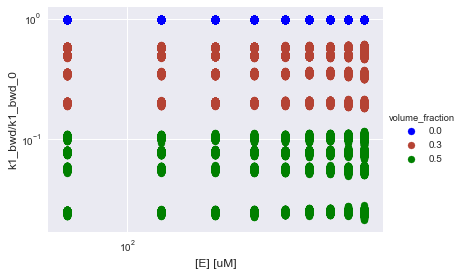

In [66]:
# plot 1 subfigure with the desired rate constant and concentration
plot_fig2_supp(data_k_conc, 'k1_bwd_relative', 'k1_bwd/k1_bwd_0', 'E', '[E] [uM]')

()

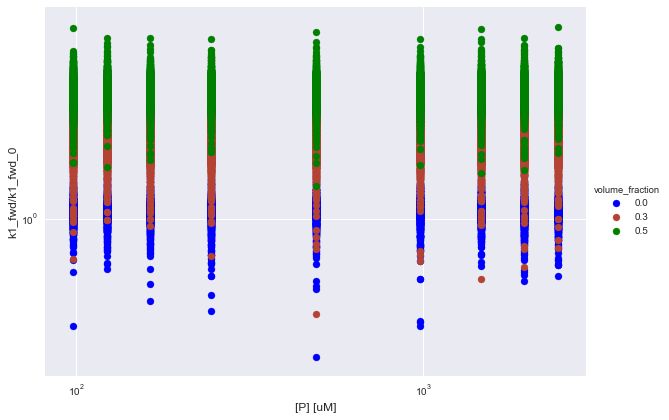

In [68]:
# other trial with y2 and P 
regression_scatterplot(data_k_conc, 'k1_fwd_relative', 'k1_fwd/k1_fwd_0', 'P', '[P] [uM]')

In [ ]:
plt.scatter(data['log_k1_bwd'], data['E'])
plt.show() 

#  <span style="color:red"> *Garbage, don't look* </span>.

Linear regression to estimate $\beta$ and $\alpha_j$ in the following model:

\begin{equation*}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \alpha_{E,j}log(\frac{[E]}{[E]_0}) + \alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \alpha_{P,j}log(\frac{[P]}{[P]_0})  + \alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation*}

where $j\in$ [1_bwd, 1_fwd, 2_bwd, 2_fwd],

$k$ is the effective rate constant, and $k_0$ is the relative rate constant

The given concentration is (??) $[X]/[X]_0$

### Check out this

As shown in supplementary figure (2) there variable variance of the data with respect to the concentration regimes. Thus ordinary least squares (OLS) fitting cannot be applied as the data exhibits heteroscedasticity. We show that we obtain normally distributed residuals by weighting
the data points by the inverse of the conditional standard deviation √𝑉(𝑅|𝑋), where 𝑋 is the n- dimensional input variable of the regression model and 𝑅 are the residuals of the OLS output variable. In supplementary figure (3) it can be clearly seen that the weighted residuals resemble a normal distribution.

Let's simplify the notation and create a dataframe with new column names and log transformed data

\begin{equation}
y_j = \beta_j + \alpha_{E,j} E_{log} + \alpha_{ES,j} ES_{log} + \alpha_{P,j} P_{log} + \alpha_{S,j} S_{log}
\end{equation}

normalization not taken into account for now

In [7]:
# create transformed dataframe
data_trans = data.copy()
data_trans['y1_bwd'] = np.log(data_trans['k1_bwd_effective']/data_trans['k1_bwd_relative'])
data_trans['y1_fwd'] = np.log(data_trans['k1_fwd_effective']/data_trans['k1_fwd_relative'])
data_trans['y2_bwd'] = np.log(data_trans['k2_bwd_effective']/data_trans['k2_bwd_relative'])
data_trans['y2_fwd'] = np.log(data_trans['k2_fwd_effective']/data_trans['k2_fwd_relative'])
data_trans['E'] = np.log(data_trans['enzyme_concentration'])
data_trans['ES'] = np.log(data_trans['enzyme_complex_concentration'])
data_trans['P'] = np.log(data_trans['product_concentration'])
data_trans['S'] = np.log(data_trans['substrate_concentration'])
data_trans.drop(['k1_bwd_effective','k1_bwd_relative', 'k1_fwd_effective',
                'k1_fwd_relative', 'k2_bwd_effective', 'k2_bwd_relative',
                'k2_fwd_effective', 'k2_fwd_relative', 'enzyme_concentration',
                'enzyme_complex_concentration', 'product_concentration',
                'substrate_concentration'], axis=1, inplace=True)
data_trans.head()

,mu_mass,realization,sigma_mass,volume_fraction,y1_bwd,y1_fwd,y2_bwd,y2_fwd,E,ES,P,S
0,12.1,2.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-11.959213,-9.761988,-9.230543,-9.923690
1,12.1,3.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-8.825078,-8.314252
2,31.9,5.0,0.825,0.2,2.302585,11.934139,12.706535,3.091042,-10.013302,-10.860600,-11.022305,-10.616837
3,12.1,8.0,0.000,0.4,2.302585,11.934139,12.706535,3.091042,-9.879771,-11.266065,-8.537396,-11.309985
4,12.1,4.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-9.923690,-8.825078


In [18]:
# Test for mu_mass = 31.9, sigma_mass = 0.825, volume_fraction = 0
data_test = data_trans[(data_trans.mu_mass == 31.9) & (data_trans.sigma_mass == 0.825) & (data_trans.volume_fraction == 0)]
print(data_test.shape)
data_test.head()

(7290, 12)


,mu_mass,realization,sigma_mass,volume_fraction,y1_bwd,y1_fwd,y2_bwd,y2_fwd,E,ES,P,S
10,31.9,0.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-10.860600,-10.013302,-9.230543,-8.314252
19,31.9,3.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-10.013302,-10.860600,-9.230543,-11.022305
41,31.9,2.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-11.309985,-8.314252
44,31.9,2.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-10.616837,-8.825078
104,31.9,9.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-11.022305,-10.616837


In [26]:
(data_test.y1_bwd - 2.30258509299404).unique()

array([5.77315973e-15, 6.21724894e-15, 5.32907052e-15])

In [20]:
# fit regression

def linear_regression(X,y):
    reg = LinearRegression()
    reg.fit(X, y)
    
    # return beta and alphas
    return (reg.intercept_, reg.coef_)
    

In [21]:
# prepare the data, regression for k1_bwd
x = data_test[['E', 'ES', 'P', 'S']].values
X = np.c_[np.ones(len(x)), x]
y = data_test['y1_bwd']

coefficients = linear_regression(X,y)
print(coefficients)

(2.302585092994046, array([ 0.00000000e+00,  4.61584006e-18,  5.00541733e-18, -9.03340671e-19,
       -9.95289291e-19]))


completely wrong, expect: -1.48e-02, 1.9e-04, 1.89e-05, -2.94e-03, -2.94e-03

### Try with normal normalization

In [22]:
def standardize(x):
    """Standardize a column."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    if std_x != 0:
        x = x / std_x
    return x, mean_x, std_x

def standardize_data(data):
    '''
    normalization of a data_set
    '''
    data_tr = data.copy()
    
    for i in range(0,data.shape[1]):
        data_tr.iloc[:,i],mean,variance = standardize(data_tr.iloc[:,i])

    return data

In [23]:
data_test_norm = standardize_data(data_test)
data_test_norm.head()

,mu_mass,realization,sigma_mass,volume_fraction,y1_bwd,y1_fwd,y2_bwd,y2_fwd,E,ES,P,S
10,31.9,0.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-10.860600,-10.013302,-9.230543,-8.314252
19,31.9,3.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-10.013302,-10.860600,-9.230543,-11.022305
41,31.9,2.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-11.309985,-8.314252
44,31.9,2.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-10.616837,-8.825078
104,31.9,9.0,0.825,0.0,2.302585,11.934139,12.706535,3.091042,-9.761988,-11.959213,-11.022305,-10.616837


In [13]:
data_test_norm.y1_bwd.unique()

array([ 0.        ,  2.40508464, -2.40508464])

In [14]:
X = np.c_[np.ones(len(x)), x]
y = data_test['y1_bwd']

coefficients = linear_regression(X,y)
print(coefficients)

(0.48394498741684555, array([ 0.        ,  0.02499832,  0.02710818, -0.00489228, -0.00539026]))


expected: -1.48e-02, 1.9e-04, 1.89e-05, -2.94e-03, -2.94e-03,

It's already closer

### Try with weird normalization

inverse of the conditional standard deviation √𝑉(𝑅|𝑋), is that: S = $\sqrt{(\frac{SSE}{n-2})}$, calculated on the complete dataset, or only per condition? 

# note de Charles: comme la formule donne du n-2 en dénominateur, il s'agit forcément du modèle "simple" donc "only per condition" d'après ta façon de dire: on a donc pour chaque transformation logarithmique des concentrations que le point est estimé à partir des résidus d'une régression du type:

\begin{equation*}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \alpha_{E,j}log(\frac{[E]}{[E]_0})
\end{equation*}